In [ ]:
# https://medium.com/@black_swan/how-to-train-word2vec-and-fasttext-embedding-on-wikipedia-corpus-9e8ac45a0c0a
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html


In [1]:
import pandas as pd
import praw
import re
import nltk

import networkx as nx
import gensim.models
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numba 

C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv("../Data/wsb_cleaned.csv")

Preprocessing:

Some guides: https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57

In [5]:
corpus = df['title']#.append(df['selftext'])
corpus[0]

'Good time to get on $BLUE'

In [7]:
regex = re.compile('[^a-zA-Z ]')

#@numba.jit # unfortunately this doesn't jit easily :(
def clean_up(text):
    # given a body of text, this splits into sentences, then processes each word in the sentence to remove
    # non alphabetical characters... (? bad idea)
    # returns it as a list of lists of words, the format desired by gensims word2vec
    
    sentences = []
    if type(text) == str:
        for sentence in nltk.tokenize.sent_tokenize(text):
            processed = [regex.sub('', word.lower()) for word in sentence.split(' ') ]
            processed = [word for word in processed if word not in set( ['', [] ])]
            sentences.append(processed)
    return sentences

In [8]:
df['tokenized_title'] = df.title.apply(clean_up)

In [11]:
df.tokenized_title

0                          [[good, time, to, get, on, blue]]
1          [[i, wanna, buy, a, call, but, i, dont, want, ...
2                                          [[buy, intu, dd]]
3          [[if, you, thought, your, was, bad, at, least,...
4                                      [[i, will, remember]]
                                 ...                        
1260232                [[aso, technical, breakout, and, dd]]
1260233                            [[first, yolo, on, crsr]]
1260234                               [[rkt, to, the, moon]]
1260235    [[my, therapist, told, me, im, delusional, for...
1260236    [[cciv, lucid, motors, testing, their, fsd, in...
Name: tokenized_title, Length: 1260237, dtype: object

In [27]:
corpus = []

for tokenized in df['tokenized_title']:
    corpus += tokenized

In [28]:
corpus

[['good', 'time', 'to', 'get', 'on', 'blue'],
 ['i',
  'wanna',
  'buy',
  'a',
  'call',
  'but',
  'i',
  'dont',
  'want',
  'to',
  'bet',
  'too',
  'much'],
 ['buy', 'intu', 'dd'],
 ['if',
  'you',
  'thought',
  'your',
  'was',
  'bad',
  'at',
  'least',
  'you',
  'arent',
  'daily',
  'discussion',
  'guys',
  'friend'],
 ['i', 'will', 'remember'],
 ['change',
  'my',
  'mind',
  'nothing',
  'is',
  'priced',
  'in',
  'stock',
  'market',
  'will',
  'always',
  'go',
  'up'],
 ['eventually'],
 ['chwy', 'to', 'the', 'moon'],
 ['new', 'years', 'challenge', 'k', 'makeit', 'or', 'breakit'],
 ['was', 'a', 'good', 'year'],
 ['new', 'strat', 'literally', 'cant', 'go', 'tits', 'up'],
 ['how',
  'many',
  'of',
  'you',
  'tisms',
  'are',
  'doing',
  'the',
  'uprotmf',
  'mix'],
 ['the', 'slight', 'hump', 'up', 'is', 'when', 'i', 'discovered', 'options'],
 ['the', 'illusive', 'yet', 'undeniable', 'bullish', 'fd', 'etf'],
 ['exclusive',
  'airbus',
  'beats',
  'goal',
  'with',

In [ ]:

model = gensim.models.Word2Vec(sentences = corpus,  min_count=10, vector_size=300, epochs = 4)


In [300]:
# Weird stuff in the vocabulary:

model.wv.key_to_index['p']

667

In [301]:
model.wv.key_to_index

{'the': 0,
 'to': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'is': 5,
 'gme': 6,
 'this': 7,
 'on': 8,
 'of': 9,
 'in': 10,
 'for': 11,
 'you': 12,
 'my': 13,
 'it': 14,
 'buy': 15,
 'we': 16,
 'amc': 17,
 'are': 18,
 'what': 19,
 'hold': 20,
 'all': 21,
 'with': 22,
 'not': 23,
 'up': 24,
 'moon': 25,
 'just': 26,
 'im': 27,
 'stock': 28,
 'me': 29,
 'robinhood': 30,
 'at': 31,
 'be': 32,
 'but': 33,
 'can': 34,
 'do': 35,
 'that': 36,
 'from': 37,
 'now': 38,
 'have': 39,
 'will': 40,
 'its': 41,
 'how': 42,
 'like': 43,
 'if': 44,
 'get': 45,
 'they': 46,
 'about': 47,
 'go': 48,
 'your': 49,
 'dont': 50,
 'or': 51,
 'going': 52,
 'out': 53,
 'so': 54,
 'today': 55,
 'short': 56,
 'us': 57,
 'new': 58,
 'lets': 59,
 'market': 60,
 'more': 61,
 'next': 62,
 'wsb': 63,
 'why': 64,
 'k': 65,
 'shares': 66,
 'time': 67,
 'when': 68,
 'stocks': 69,
 'here': 70,
 'sell': 71,
 'holding': 72,
 'nok': 73,
 'money': 74,
 'one': 75,
 'still': 76,
 'down': 77,
 'trading': 78,
 'as': 79,
 'bb': 80,
 'some

In [120]:
model_fasttext = gensim.models.FastText(sentences = sentences,  min_count=10, vector_size=200, epochs = 4)

In [308]:
def sims(args, model):
    for word, sim in model.wv.most_similar(**args, topn = 10):
        print( f"{word} - similarity {sim}")

In [309]:
sims(args = {'positive': ['gme'], 'negative' : []} , model = model)

amc - similarity 0.5596492290496826
nok - similarity 0.5361988544464111
bb - similarity 0.5224165320396423
gmeamc - similarity 0.5203821063041687
gamestop - similarity 0.515713632106781
cashapp - similarity 0.5062443017959595
pltr - similarity 0.4708917438983917
shares - similarity 0.452474981546402
gmc - similarity 0.44781261682510376
tsla - similarity 0.44304734468460083


In [310]:
sims(args = {'positive': ['gme'], 'negative' : []} , model = model_fasttext)

gmegme - similarity 0.9481385350227356
bbgme - similarity 0.9052594304084778
xgme - similarity 0.9008151888847351
gmegmegme - similarity 0.8996497392654419
gmei - similarity 0.8739570379257202
gmebb - similarity 0.8691338300704956
rgme - similarity 0.845234215259552
gmebbamc - similarity 0.8380964398384094
gmebbnok - similarity 0.8310365676879883
amcgme - similarity 0.8301228284835815


In [311]:
sims(args = {'positive': ['tendies'], 'negative' : []} , model = model)

trendies - similarity 0.7475232481956482
tenders - similarity 0.6288326978683472
bananas - similarity 0.6108847856521606
gains - similarity 0.6084863543510437
monies - similarity 0.5755869150161743
profits - similarity 0.5664299726486206
gainz - similarity 0.5496600866317749
money - similarity 0.544853687286377
crayons - similarity 0.5436545014381409
winnings - similarity 0.5323022603988647


In [312]:
sims(args = {'positive': ['normies'], 'negative' : []} , model = model)

boomers - similarity 0.7146612405776978
redditors - similarity 0.6555109024047852
algos - similarity 0.6369420289993286
journalists - similarity 0.598860502243042
shills - similarity 0.5836716294288635
polls - similarity 0.5822686553001404
millennials - similarity 0.5768738985061646
wsbers - similarity 0.5668399333953857
elites - similarity 0.5641976594924927
billionaires - similarity 0.5615935921669006


In [313]:
sims(args = {'positive': ['brain', 'tendies'], 'negative' : ['wrinkles']} , model = model)

gains - similarity 0.47921043634414673
wife - similarity 0.46413469314575195
money - similarity 0.45455101132392883
gf - similarity 0.4539561867713928
mom - similarity 0.4487594664096832
profits - similarity 0.43259209394454956
dreams - similarity 0.4095911383628845
fellow - similarity 0.4055059254169464
gainz - similarity 0.4033401310443878
dad - similarity 0.39909127354621887


In [314]:
sims(args = {'positive': ['king', 'woman'], 'negative' : ['man']} , model = model)

patron - similarity 0.6436852812767029
overlord - similarity 0.6357335448265076
saint - similarity 0.6329671740531921
prophet - similarity 0.6300493478775024
leader - similarity 0.6242414116859436
queen - similarity 0.6132948398590088
messiah - similarity 0.6116687059402466
saviour - similarity 0.5942792892456055
visits - similarity 0.5933437347412109
goat - similarity 0.5864658951759338


In [315]:
sims(args = {'positive': ['lol']} , model = model)

lmao - similarity 0.7247433662414551
cuz - similarity 0.5503053069114685
haha - similarity 0.5428436398506165
kinda - similarity 0.4847038984298706
tho - similarity 0.46267732977867126
yeah - similarity 0.4620051085948944
bc - similarity 0.45689597725868225
wow - similarity 0.4395608603954315
huh - similarity 0.42913562059402466
honestly - similarity 0.4153261184692383


In [321]:
## Saving and loading

import tempfile

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
    # To load a saved model:
    #
    new_model = gensim.models.Word2Vec.load(temporary_filepath)

Some preliminary regression /classification below -- this is slated to get moved

In [319]:
def average_vector(text, model):
    present_keys = [x for x in text if x in model.wv.key_to_index ]
    if not present_keys:
        return [0] * len( model.wv[ model.wv.index_to_key[0]])
    return sum( [model.wv[x] for x in present_keys] ) /len(present_keys)

In [320]:
df['avg_vector'] = df['title'].apply(lambda x : average_vector(x, model))

TypeError: 'float' object is not iterable

In [148]:
## Most similar posts?
import sklearn 
def similarity(vec_1, vec_2):
    return sklearn.metrics.pairwise.cosine_similarity([vec_1], [vec_2])[0]

def make_similarity_col(df, given_index):
    given_vector = df['avg_vector'][given_index] 
    df['similarity'] = df['avg_vector'].apply( lambda x : similarity(x, given_vector))
    

In [149]:
make_similarity_col(df, 0)

In [152]:
## Question: Can we find 'essentially reposts'?
df_s = df.sort_values(by='similarity', ascending = False)
df_s.head(10)

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups,total_awards_received,num_comments,num_crossposts,is_self,is_video,media_only,id,created_utc,selftext_html,author_fullname,avg_vector,similarity
0,0,good time to get on blue,none,2020-01-01 23:53:34,deleted,https://www.reddit.com/r/wallstreetbets/commen...,0.75,6,0,17,0,True,False,False,eipxnr,1.577923e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[2.1071084, -0.97820675, 0.2956134, -0.3804265...",[1.0]
944207,644935,doge going to the moon better buy in,none,2021-02-03 21:11:41,removed,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,0,True,False,False,lbyew4,1.612387e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",NaN,"[2.0063856, -0.9330258, 0.23380613, -0.4231665...",[0.99570775]
1207743,908471,no doubt gme will go to the moon,sherwoodlax,2021-04-01 20:05:50,nan,https://www.reddit.com/gallery/mi3ruu,1.00,1,0,1,0,False,False,False,mi3ruu,1.617308e+09,NaN,t2_a82na17m,"[2.02061, -0.88645613, 0.1666097, -0.40067506,...",[0.99310094]
1206182,906910,need more volume got to get it,rjacobo,2021-03-31 15:19:21,nan,https://i.redd.it/016xear5sdq61.jpg,0.67,1,0,4,0,False,False,False,mh8dsh,1.617204e+09,NaN,t2_2v7d97c8,"[1.9780279, -0.87360835, 0.28289443, -0.388272...",[0.99294454]
522395,223123,robinhood not letting me get money out,electronictrust,2021-01-28 14:19:14,removed,https://www.reddit.com/r/wallstreetbets/commen...,1.00,5,0,7,0,True,False,False,l6xqm8,1.611844e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_9ovx6pwa,"[2.0218751, -0.88488835, 0.15176122, -0.453048...",[0.9928003]
994308,695036,buy doge going to the moon,mindlessbreakfast,2021-02-04 12:20:23,nan,https://twitter.com/elonmusk/status/1357244295...,1.00,1,0,0,0,False,False,False,lcegr6,1.612441e+09,NaN,t2_a2d4d7d3,"[1.987613, -0.9396037, 0.18952513, -0.2586579,...",[0.99275154]
670585,371313,robin hood not letting me buy doge,agentk,2021-01-29 03:33:54,removed,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,0,True,False,False,l7hzte,1.611891e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_17c1gi,"[2.0529141, -0.9181442, 0.1900111, -0.4975027,...",[0.9926019]
529889,230617,going to move to webull,jimthewhiterunguard,2021-01-28 13:39:13,fuck robinhood,https://www.reddit.com/r/wallstreetbets/commen...,0.92,9,0,3,0,True,False,False,l6wt07,1.611841e+09,"<!-- SC_OFF --><div class=""md""><p>Fuck robinho...",t2_2xlybqaw,"[1.9064927, -0.9006917, 0.21931693, -0.3781596...",[0.99231553]
840229,540957,etoro not letting me buy gme,none,2021-02-01 14:44:14,removed,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,0,True,False,False,la4l9a,1.612191e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",NaN,"[1.9525312, -0.9112648, 0.23887798, -0.3972511...",[0.9920423]
690182,390910,robinhood letter begging to not be sued,carfrk,2021-01-29 00:07:34,removed,https://www.reddit.com/r/wallstreetbets/commen...,0.66,1,0,0,0,True,False,False,l7dd2l,1.611879e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_15t9uj,"[1.9633255, -0.93526036, 0.2533758, -0.5162953...",[0.9919332]


In [153]:
# We can also do  clustering here ? 
# https://stackoverflow.com/questions/9156961/hierarchical-clustering-of-1-million-objects

In [155]:
X = np.vstack(df['avg_vector'].to_numpy())
y = df['ups']

In [156]:
X

array([[ 2.10710835, -0.97820675,  0.29561341, ...,  0.24624813,
        -0.40328106,  0.2453102 ],
       [ 1.96537781, -0.53625095,  0.48325655, ...,  0.4807539 ,
         0.18763466,  0.231345  ],
       [ 2.25719285, -0.73185343,  0.15753916, ...,  0.7149561 ,
         0.17202167,  0.20758048],
       ...,
       [ 2.09694934, -0.62246865,  0.15998653, ...,  0.46289149,
        -0.4624677 , -0.02487645],
       [ 1.90477479, -0.62298346,  0.29116109, ...,  0.32019651,
         0.08719403,  0.15182419],
       [ 1.99856377, -0.59056246,  0.05899508, ...,  0.57210487,
         0.24809372,  0.15379924]])

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

935262     222
416369       1
382858      18
884008       1
761128       1
          ... 
1114747      4
408280       2
888239       1
1010336      1
508714       3
Name: ups, Length: 252048, dtype: int64

In [158]:
from sklearn.metrics import mean_squared_error

# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

3516449.6186454897

<AxesSubplot:xlabel='0', ylabel='1'>

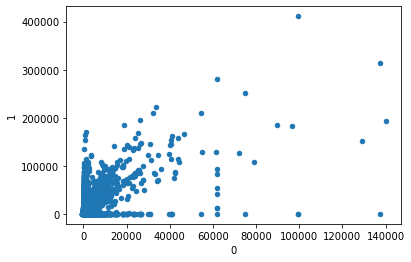

In [181]:
plot = pd.DataFrame([xgr.predict(X_train), y_train])
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [100]:

plot = pd.DataFrame([y_pred, y_test])

<AxesSubplot:xlabel='0', ylabel='1'>

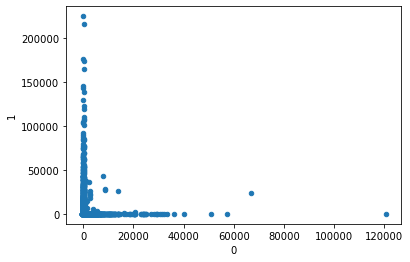

In [159]:
plot.transpose().plot(kind = 'scatter', x = 0, y = 1)

In [165]:

output = pd.DataFrame(y_test)
output['pred'] = y_pred

In [171]:
df_with_pred = df.merge(output, right_index = True, left_index = True)

In [174]:
df_with_pred.sort_values(by = 'pred', ascending = False)

,Unnamed: 0,title,author,created_datetime_utc,selftext,url,upvote_ratio,ups_x,total_awards_received,num_comments,...,is_video,media_only,id,created_utc,selftext_html,author_fullname,avg_vector,similarity,ups_y,pred
774020,474748,forever never dies,none,2021-01-31 11:31:38,deleted,https://i.redd.it/sx08zn1rlne61.jpg,1.00,1,0,0,...,False,False,l9altm,1.612093e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[1.5393746, -0.68029225, 0.18800707, -0.732837...",[0.88995945],1,129129.296875
718454,419182,welcome to the endgame,none,2021-01-30 13:44:11,deleted,https://streamable.com/4lol9t,0.67,1,0,1,...,False,False,l8lz44,1.612014e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[1.9341128, -0.7926674, 0.44564953, -0.469884,...",[0.9575975],1,72273.195312
314392,15120,gme yolo update jan,deepfuckingvalue,2021-01-14 21:03:13,nan,https://i.redd.it/dxc04m314db61.png,0.97,24255,197,1604,...,False,False,kxeq23,1.610658e+09,NaN,t2_49l8qytq,"[1.7628586, -0.56726193, 0.45402333, -0.575014...",[0.9313593],24255,61682.039062
843826,544554,there is no silver short squeeze happening non...,majestichandle,2021-02-01 13:51:03,removed,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,False,False,la3h37,1.612187e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_84feq39m,"[1.6771866, -0.7346322, 0.17244963, -0.5704492...",[0.92732203],1,42207.101562
821281,522009,there is no silver short squeeze happening non...,onboarding,2021-02-01 17:39:36,nan,https://www.reddit.com/r/wallstreetbets/commen...,1.00,1,0,0,...,False,False,la8z3w,1.612201e+09,NaN,t2_9yc6gs88,"[1.6771866, -0.7346322, 0.17244963, -0.5704492...",[0.92732203],1,42207.101562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066640,767368,sxc,kenmeansyes,2021-02-17 19:40:13,nan,https://i.redd.it/s2trq6x9c3i61.png,1.00,1,0,0,...,False,False,lm2r9k,1.613591e+09,NaN,t2_a0sm1gqq,"[2.028814, -0.38747144, 0.21785854, 0.03631463...",[0.51870126],1,-689.110535
502441,203169,rrc,researcherfunny,2021-01-28 15:24:10,removed,https://www.reddit.com/r/wallstreetbets/commen...,0.33,0,0,0,...,False,False,l6zkcp,1.611847e+09,"<!-- SC_OFF --><div class=""md""><p>[removed]</p...",t2_8a8rusi5,"[1.6028289, -0.21937473, -0.689915, -0.7976985...",[0.5677874],0,-812.436401
48972,48972,futures uuupppppp for now,controlplusz,2020-03-09 23:07:06,nan,https://www.cnbc.com/2020/03/09/dow-futures-fa...,0.93,99,0,187,...,False,False,fg3srd,1.583795e+09,NaN,t2_4ewo25vb,"[1.9678787, -0.27154619, -0.14154428, -0.58761...",[0.7364304],99,-850.473877
1157222,857950,no funds no fun,none,2021-03-09 02:15:16,deleted,https://i.redd.it/gkqumqq7wwl61.jpg,1.00,1,0,0,...,False,False,m0wd33,1.615256e+09,"<!-- SC_OFF --><div class=""md""><p>[deleted]</p...",NaN,"[1.5684566, -0.514331, -0.51395595, -0.6512546...",[0.82205725],1,-1022.922180


In [176]:
df['pred'] = xgr.predict( np.vstack(df['avg_vector'].to_numpy()))

<AxesSubplot:xlabel='ups', ylabel='pred'>

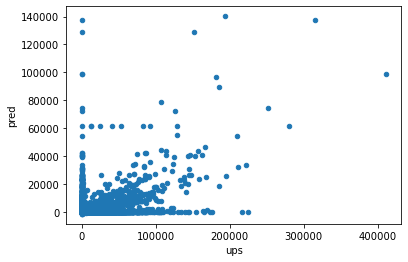

In [180]:
df.plot(kind = 'scatter', x = 'ups', y = 'pred')

In [185]:
df.selftext[4]

'removed'